<a href="https://colab.research.google.com/github/stomioka/phuse-tumor-ml/blob/master/07_dual_cnn_tumor_prediction_sites_central_google_cola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Response criteria prediction for tumor with parallel-CNN

Sam Tomioka<br>
2019-10-13

Same data used in [notebook3](03-tumor_prediction-sites-central.ipynb) will be used here. 

- Model based on `central`+`site` with 85% of data from each. Test on remaining `central` assessments, Test on remaining `site` assessments independently.

In [ ]:
#!pip install git+git://github.com/andirs/impyte.git
#!pip install xgboost 

!git clone https://github.com/stomioka/phuse-tumor-ml.git
!pip install git+git://github.com/andirs/impyte.git
!mv phuse-tumor-ml phuse_tumor_ml
import os
#os.chdir('phuse_tumor_ml/notebooks')

In [7]:

from lib.myutil import *
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.train import *
print('tensorflow version: {}'.format(tf.__version__))

import sklearn
from sklearn.metrics import accuracy_score,roc_curve, auc
print('sklearn version: {}'.format(sklearn.__version__))
import matplotlib.pyplot as plt
%matplotlib inline

tf.enable_eager_execution()

#tf.keras.backend.clear_session() 

tensorflow version: 1.14.0
sklearn version: 0.21.2


In [10]:
central, site=load_data()

tr_x, tr_y, ts_x, ts_y, ts_x2, ts_y2 = generate_tr_ts(df1=central, df2=site, m=4, method=None, h=3000, seed=2019, normalize=False,scaling_method=None)

In [11]:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()
tr_y = encoder.fit_transform(tr_y)
ts_y = encoder.fit_transform(ts_y)
ts_y2 = encoder.fit_transform(ts_y2)

In [12]:
tr_x.shape, tr_y.shape
x_train, x_vl, y_train, y_vl = train_test_split(tr_x, tr_y, test_size=0.20, random_state=2019)
print()
x_train=np.array(x_train).reshape(x_train.shape[0],7,1)
#y_train=np.array(y_train).reshape(y_train.shape[0],5,1)
x_vl=np.array(x_vl).reshape(x_vl.shape[0],7,1)
#y_vl=np.array(y_vl).reshape(y_vl.shape[0],5,1)

In [13]:
tf.keras.backend.clear_session() 
i = Input(shape=(7,1),name='recest')

x0 = Conv1D(64, 3, activation='relu', name='1Dconv_1')(i)
x0 = Conv1D(64, 3, activation='relu', name='1Dconv_2')(x0)
x0 = Dropout(0.5, name='1Dropout')(x0)
x0 = MaxPooling1D(pool_size=2, name='1maxpool')(x0)
x0 = Flatten()(x0)
x0 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='1out')(x0)

x1 = Conv1D(128, 3, activation='relu', name='2Dconv_1')(i)
x1 = Conv1D(128, 3, activation='relu', name='2Dconv_2')(x1)
x1 = Dropout(0.5, name='2Dropout')(x1)
x1 = MaxPooling1D(pool_size=2, name='2maxpool')(x1)
x1 = Flatten()(x1)
x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='2out')(x1)


#x1 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_2')(i)
x2 = Add()([x0, x1])
x2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_1')(x2)
#x2 = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_2')(x2)
#x2 = Dense(16, activation='relu', kernel_regularizer=regularizers.l2(l=0.01), name='dense_3')(x2)
x2 = Flatten()(x2)
outputs = Dense(5, activation='softmax', name='pred')(x2)

model = Model(i, outputs)
opt = AdamOptimizer(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
recest (InputLayer)             [(None, 7, 1)]       0                                            
__________________________________________________________________________________________________
1Dconv_1 (Conv1D)               (None, 5, 64)        256         recest[0][0]                     
__________________________________________________________________________________________________
2Dconv_1 (Conv1D)               (None, 5, 128)       512         recest[0][0]                     
__________________________________________________________________________________________________
1Dconv_2 (Conv1D)               (None, 3, 64)        12352       1Dconv_1[0][0]                   
______________________________________________________________________________________________

In [14]:
history = model.fit(x_train, y_train,
                    batch_size=16,
                    epochs=500,

                    validation_data=(x_vl, y_vl))

W1027 22:59:24.803376 140550692259648 deprecation.py:323] From /home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 515 samples, validate on 129 samples
Epoch 1/500
515/515 [==============================] - 3s 6ms/sample - loss: 5.4481 - acc: 0.5068 - val_loss: 3.1595 - val_acc: 0.6589
Epoch 2/500
515/515 [==============================] - 0s 823us/sample - loss: 3.5052 - acc: 0.6447 - val_loss: 2.7730 - val_acc: 0.7519
Epoch 3/500
515/515 [==============================] - 0s 782us/sample - loss: 3.1534 - acc: 0.6816 - val_loss: 2.6803 - val_acc: 0.7364
Epoch 4/500
515/515 [==============================] - 0s 778us/sample - loss: 2.9871 - acc: 0.7184 - val_loss: 2.4982 - val_acc: 0.7442
Epoch 5/500
515/515 [==============================] - 0s 745us/sample - loss: 2.8474 - acc: 0.7029 - val_loss: 2.4180 - val_acc: 0.7674
Epoch 6/500
515/515 [==============================] - 0s 814us/sample - loss: 2.7703 - acc: 0.7049 - val_loss: 2.3507 - val_acc: 0.7597
Epoch 7/500
515/515 [==============================] - 0s 868us/sample - loss: 2.6644 - acc: 0.7184 - val_loss: 2.2814 - val_acc: 0.74

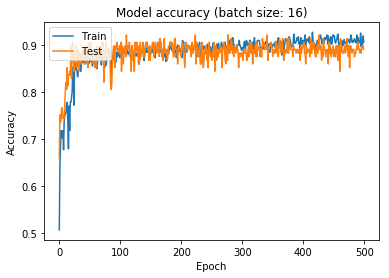

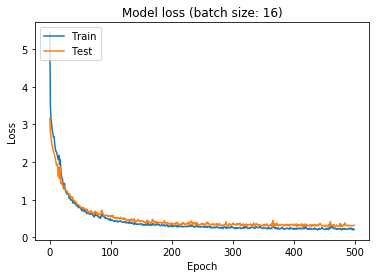

In [15]:
plot_hist(history)

In [16]:
ts_x=np.array(ts_x).reshape(ts_x.shape[0],7,1)
results1=model.evaluate(ts_x, ts_y, batch_size=32)
print('\nm=3, test=C\n test loss: {}\n  test acc: {}'.format(results1[0],results1[1]))

276/276 [==============================] - 1s 2ms/sample - loss: 0.4183 - acc: 0.8587

m=3, test=C
 test loss: 0.4182543778333111
  test acc: 0.8586956262588501


In [17]:
ts_x2=np.array(ts_x2).reshape(ts_x2.shape[0],7,1)
results2=model.evaluate(ts_x2, ts_y2, batch_size=32)
print('\nm=3, test=D\n test loss: {}\n  test acc: {}'.format(results2[0],results2[1]))

695/695 [==============================] - 0s 542us/sample - loss: 0.2521 - acc: 0.9209

m=3, test=D
 test loss: 0.2521416136418744
  test acc: 0.9208633303642273


In [18]:
## check where model did not predict correctly

In [24]:
_, _, ts_x_df, ts_y_lbl, ts_x2_df, ts_y2_lbl = generate_tr_ts(df1=central, df2=site, m=4, method=None, h=3000, seed=2019, normalize=False,scaling_method=None)

In [25]:
def prediction(encoder, model, test_x):
    pred=model.predict(test_x)
    return encoder.inverse_transform(np.round(pred))
def return_predict(encoder, model, test_x, test_y):
    pred=prediction(encoder, model, test_x)
    results=[pred==true for pred, true in list(zip(pred,test_y))]
    return results

In [27]:
ts_x_df['Label']=ts_y_lbl['TRGRESP']
ts_x_df['Pred']=prediction(encoder, model, ts_x)
ts_x_df['Correct']=return_predict(encoder, model, ts_x, ts_y_lbl['TRGRESP'])
ts_x_df

,BSUM,SUMDIAM,PCBSD,NADIR,ACNSD,PCNSD,NEWLSN,Label,Pred,Correct
154,34,18.0,-47.058824,19,-1.0,-5,0,PR,PR,True
809,88,24.0,-72.727273,19,5.0,26,0,PD,CR,False
821,147,64.0,-56.462585,82,-18.0,-22,0,PR,PR,True
845,60,34.0,-43.333333,35,-1.0,-3,1,PR,PR,True
430,111,61.0,-45.045045,111,-50.0,-45,0,PR,PR,True
435,46,36.0,-21.739130,46,-10.0,-22,0,SD,SD,True
97,183,70.0,-61.748634,75,-5.0,-7,1,PR,PR,True
191,180,127.0,-29.444444,180,-53.0,-29,0,SD,PR,False
81,85,56.0,-34.117647,59,-3.0,-5,1,PR,PR,True
150,107,180.0,68.224299,107,73.0,68,1,PD,PD,True


In [28]:
ts_x2_df['Label']=ts_y2_lbl['TRGRESP']
ts_x2_df['Pred']=prediction(encoder, model, ts_x2)
ts_x2_df['Correct']=return_predict(encoder, model, ts_x2, ts_y2_lbl['TRGRESP'])
ts_x2_df

,BSUM,SUMDIAM,PCBSD,NADIR,ACNSD,PCNSD,NEWLSN,Label,Pred,Correct
0,53.0,107.0,101.886792,53.0,54.0,102,1,PD,PD,True
1,37.0,21.0,-43.243243,37.0,-16.0,-43,0,PR,PR,True
2,37.0,18.0,-51.351351,21.0,-3.0,-14,0,PR,PR,True
3,37.0,0.0,-100.000000,5.0,-5.0,-100,0,CR,CR,True
4,37.0,0.0,-100.000000,0.0,0.0,0,0,CR,CR,True
5,37.0,0.0,-100.000000,0.0,0.0,0,0,CR,CR,True
6,44.0,70.0,59.090909,44.0,26.0,59,1,PD,PD,True
7,30.0,12.0,-60.000000,30.0,-18.0,-60,0,PR,PR,True
8,30.0,0.0,-100.000000,12.0,-12.0,-100,0,CR,CR,True
9,30.0,15.0,-50.000000,0.0,15.0,0,0,PD,CR,False
